##Data Load

In [1]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d saipavansaketh/eurosatland

Dataset URL: https://www.kaggle.com/datasets/saipavansaketh/eurosatland
License(s): unknown
100% 90.0M/90.4M [00:06<00:00, 23.6MB/s]
100% 90.4M/90.4M [00:06<00:00, 15.2MB/s]


In [3]:
!unzip /content/eurosatland.zip

Streaming output truncated to the last 5000 lines.
  inflating: archive (1)/2750/River/River_1451.jpg  
  inflating: archive (1)/2750/River/River_1452.jpg  
  inflating: archive (1)/2750/River/River_1453.jpg  
  inflating: archive (1)/2750/River/River_1454.jpg  
  inflating: archive (1)/2750/River/River_1455.jpg  
  inflating: archive (1)/2750/River/River_1456.jpg  
  inflating: archive (1)/2750/River/River_1457.jpg  
  inflating: archive (1)/2750/River/River_1458.jpg  
  inflating: archive (1)/2750/River/River_1459.jpg  
  inflating: archive (1)/2750/River/River_146.jpg  
  inflating: archive (1)/2750/River/River_1460.jpg  
  inflating: archive (1)/2750/River/River_1461.jpg  
  inflating: archive (1)/2750/River/River_1462.jpg  
  inflating: archive (1)/2750/River/River_1463.jpg  
  inflating: archive (1)/2750/River/River_1464.jpg  
  inflating: archive (1)/2750/River/River_1465.jpg  
  inflating: archive (1)/2750/River/River_1466.jpg  
  inflating: archive (1)/2750/River/River_1467.jp

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow as tf
from PIL import Image
import os
from tensorflow import keras
from tensorflow.keras.initializers import random_uniform, glorot_uniform
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Input, Add, Activation, ZeroPadding2D, BatchNormalization, MaxPooling2D, AveragePooling2D, Conv2D, Flatten, Dense
from tensorflow.keras.initializers import random_uniform, glorot_uniform
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

##Hyperparameters

In [5]:
dataset_url = '/content/archive (1)/2750'

batch_size = 32
img_height = 64
img_width = 64
validation_split=0.2
rescale=1.0/255

##Generator

In [6]:
#train_datagen
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                                          validation_split=validation_split,
                                                          rescale=rescale,
                                                          rotation_range=30,
                                                          width_shift_range=0.3,
                                                          height_shift_range=0.3,
                                                          horizontal_flip=True,
                                                          brightness_range=[0.75,1.25])
data = datagen.flow_from_directory(
                                    dataset_url,
                                    target_size=(64, 64),
                                    batch_size=32,
                                    class_mode='categorical',
                                    classes=['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

)

Found 27000 images belonging to 10 classes.


In [7]:
#tf.keras.utils.image_dataset_from_directory
train_dataset = datagen.flow_from_directory(
                                            directory=dataset_url,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            target_size=(img_height, img_width),

                                            subset="training",
                                            class_mode='categorical')

Found 21600 images belonging to 10 classes.


In [8]:
val_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="validation",
                                           class_mode='categorical')

Found 5400 images belonging to 10 classes.


##Plotting data

In [9]:
df = pd.read_csv('/content/train (1).csv')
df.head()

,Unnamed: 0,Filename,Label,ClassName
0,16257,AnnualCrop/AnnualCrop_142.jpg,0,AnnualCrop
1,3297,HerbaceousVegetation/HerbaceousVegetation_2835...,2,HerbaceousVegetation
2,17881,PermanentCrop/PermanentCrop_1073.jpg,6,PermanentCrop
3,2223,Industrial/Industrial_453.jpg,4,Industrial
4,4887,HerbaceousVegetation/HerbaceousVegetation_1810...,2,HerbaceousVegetation


In [10]:
class_names=df['ClassName'].unique()
class_names

array(['AnnualCrop', 'HerbaceousVegetation', 'PermanentCrop',
       'Industrial', 'Pasture', 'Highway', 'Residential', 'River',
       'SeaLake', 'Forest'], dtype=object)

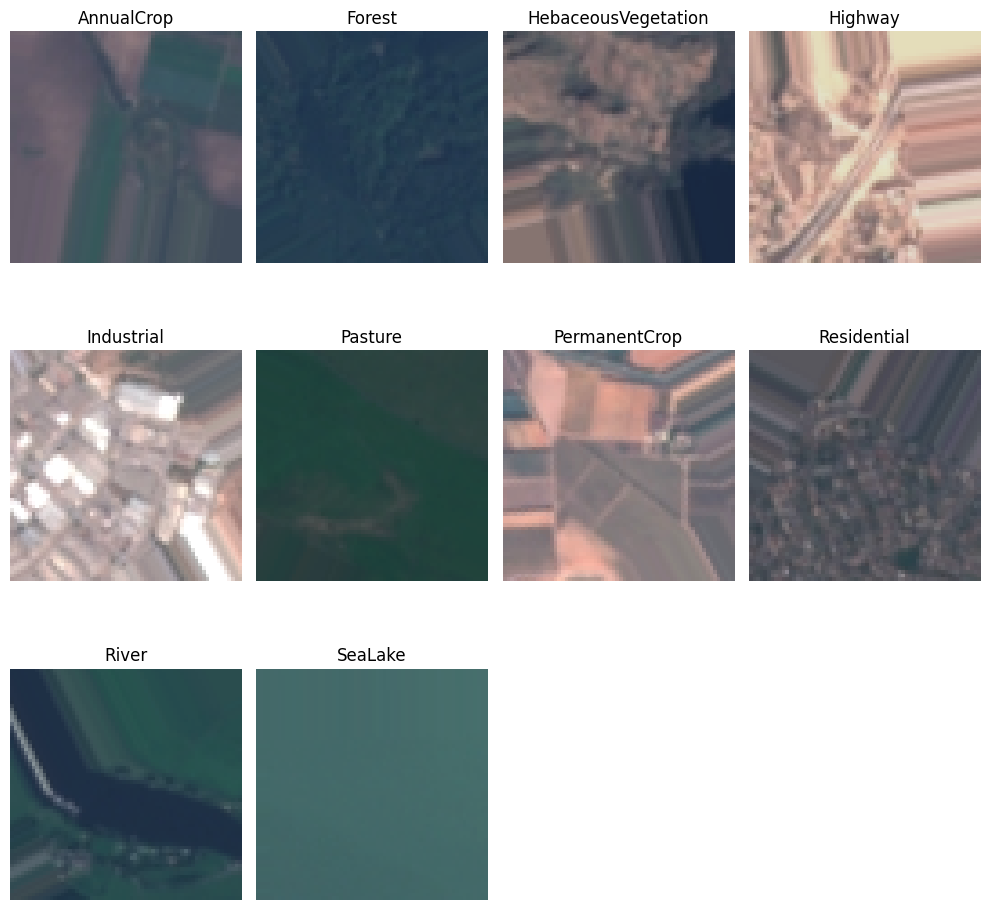

In [11]:
batch_images, batch_labels = next(data)
class_labels = ['AnnualCrop', 'Forest', 'HebaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
plt.figure(figsize=(10, 10))
for i, label in enumerate(class_labels):
    # Find the index of the first occurrence of the label
    class_index = np.argmax(batch_labels, axis=1) == i
    class_image = batch_images[class_index][0]

    # Plot the image
    plt.subplot(3, 4, i + 1)
    plt.imshow(class_image)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
import pandas as pd

# Count samples in each class
class_counts = df["ClassName"].value_counts()

# Convert to a DataFrame (optional)
class_counts_series = class_counts.reset_index()
print(class_counts_series)

              ClassName  count
0            AnnualCrop   2100
1  HerbaceousVegetation   2100
2           Residential   2100
3               SeaLake   2100
4                Forest   2100
5         PermanentCrop   1750
6            Industrial   1750
7               Highway   1750
8                 River   1750
9               Pasture   1400


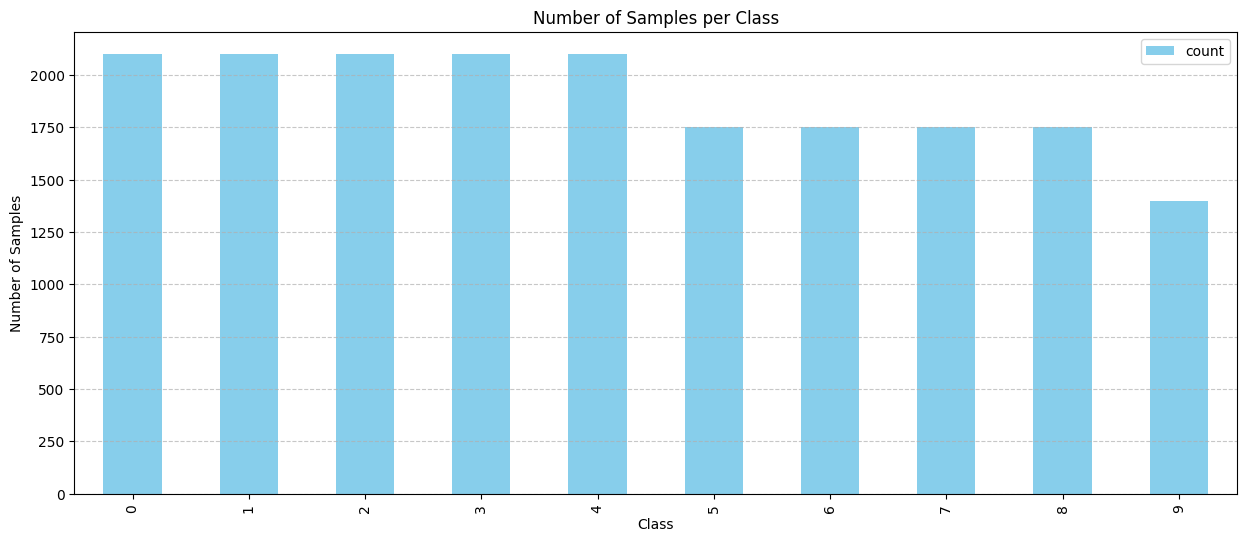

In [13]:
# Plot the data
class_counts_series.plot(kind='bar', color='skyblue', figsize=(15, 6))
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Class')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

##ResNet50

In [14]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer

    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value.
    X_shortcut = X
    cache = []
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut, X])
    X = X = Activation('relu')(X, training = training)

    return X

In [15]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer,
                   also called Xavier uniform initializer.

    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####

    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)


    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(F3, (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s, s), padding = 'valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training = training)

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [16]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)


    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

   # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size = (2, 2), name = 'avg_pool')(X)


    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)


    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

**model train**


In [17]:
model = ResNet50(input_shape=(64,64,3), classes=10)

In [18]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
history = model.fit(train_dataset, validation_data= val_dataset, epochs=20, batch_size=32)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


675/675 ━━━━━━━━━━━━━━━━━━━━ 135s 115ms/step - accuracy: 0.3774 - loss: 2.2124 - val_accuracy: 0.2780 - val_loss: 3.0548
Epoch 2/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 112s 111ms/step - accuracy: 0.5817 - loss: 1.1932 - val_accuracy: 0.1363 - val_loss: 28371.3770
Epoch 3/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 77s 113ms/step - accuracy: 0.5372 - loss: 1.3799 - val_accuracy: 0.3948 - val_loss: 2.0255
Epoch 4/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 90s 133ms/step - accuracy: 0.6575 - loss: 1.0170 - val_accuracy: 0.6233 - val_loss: 1.1493
Epoch 5/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 142s 133ms/step - accuracy: 0.6622 - loss: 1.0257 - val_accuracy: 0.5185 - val_loss: 1.4759
Epoch 6/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 87s 128ms/step - accuracy: 0.6798 - loss: 0.9600 - val_accuracy: 0.3461 - val_loss: 2.6053
Epoch 7/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 127s 106ms/step - accuracy: 0.6837 - loss: 0.9560 - val_accuracy: 0.2007 - val_loss: 3.7235
Epoch 8/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 82s 106ms/step - accuracy: 0.6614 - loss: 1.06

visuallize model layer's

In [22]:
model.save('ResNet_20_epochs.h5')

Visuallize Model Accuracy Epoch by Epoch

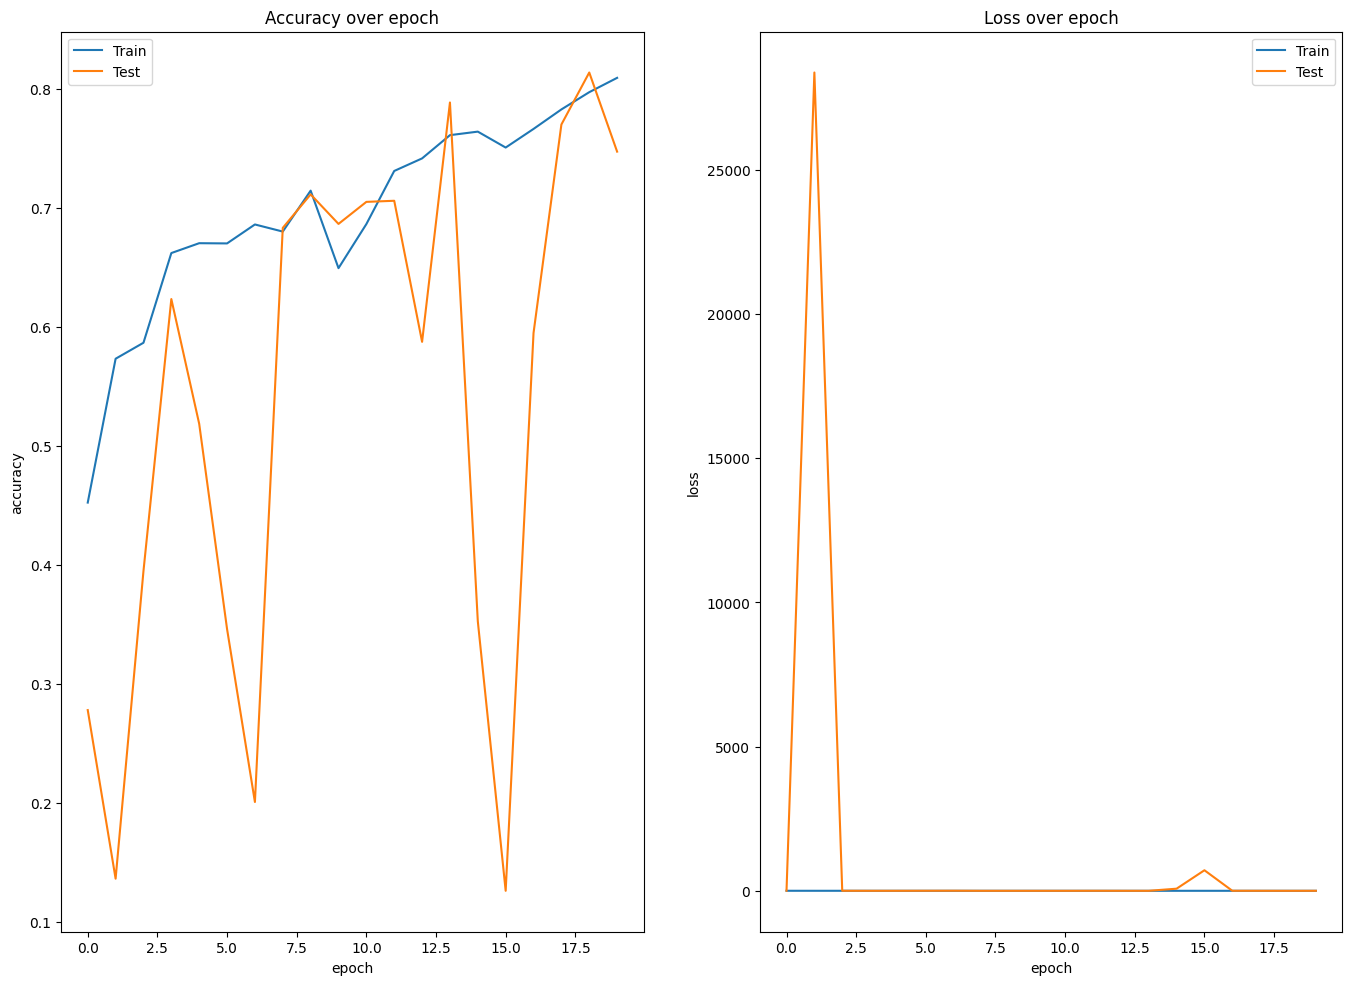

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16.53, 11.69))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.set_title('Accuracy over epoch')
ax1.legend(['Train', 'Test'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.set_title('Loss over epoch')
ax2.legend(['Train', 'Test'], loc="upper right")

In [25]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for i, (image_batch, label_batch) in enumerate(val_dataset):   # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = model.predict(image_batch)
    # append predicted labels
    y_pred.append(np.argmax(preds, axis =  1))
    if i==300:
        break

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━

In [26]:
# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
correct_labels = np.argmax(correct_labels, axis=1)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [27]:
cm = confusion_matrix(correct_labels, predicted_labels)
cm

array([[ 968,   10,    8,   25,    0,   32,    4,    0,   13,   19],
       [   0, 1034,    6,    3,    0,   25,    0,    3,    8,   10],
       [ 103,   18,  721,   55,    1,    6,  106,   14,   23,    7],
       [  68,    1,   20,  684,   21,   23,   47,   10,   16,    1],
       [  14,    0,  161,  166,  433,    0,   19,   14,   84,    0],
       [  21,   35,   22,   33,    0,  595,    2,    0,   11,    6],
       [ 212,    1,   74,  123,    1,   23,  439,    6,    9,    0],
       [   1,    0,   69,  204,   51,    1,   36,  703,    0,    0],
       [  37,   15,    9,  168,    2,   35,    3,    1,  596,    8],
       [   6,   22,    3,    6,    0,    1,    0,    0,    6, 1024]])

In [32]:
import itertools

In [33]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        figsize=(10, 10),
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 968   10    8   25    0   32    4    0   13   19]
 [   0 1034    6    3    0   25    0    3    8   10]
 [ 103   18  721   55    1    6  106   14   23    7]
 [  68    1   20  684   21   23   47   10   16    1]
 [  14    0  161  166  433    0   19   14   84    0]
 [  21   35   22   33    0  595    2    0   11    6]
 [ 212    1   74  123    1   23  439    6    9    0]
 [   1    0   69  204   51    1   36  703    0    0]
 [  37   15    9  168    2   35    3    1  596    8]
 [   6   22    3    6    0    1    0    0    6 1024]]


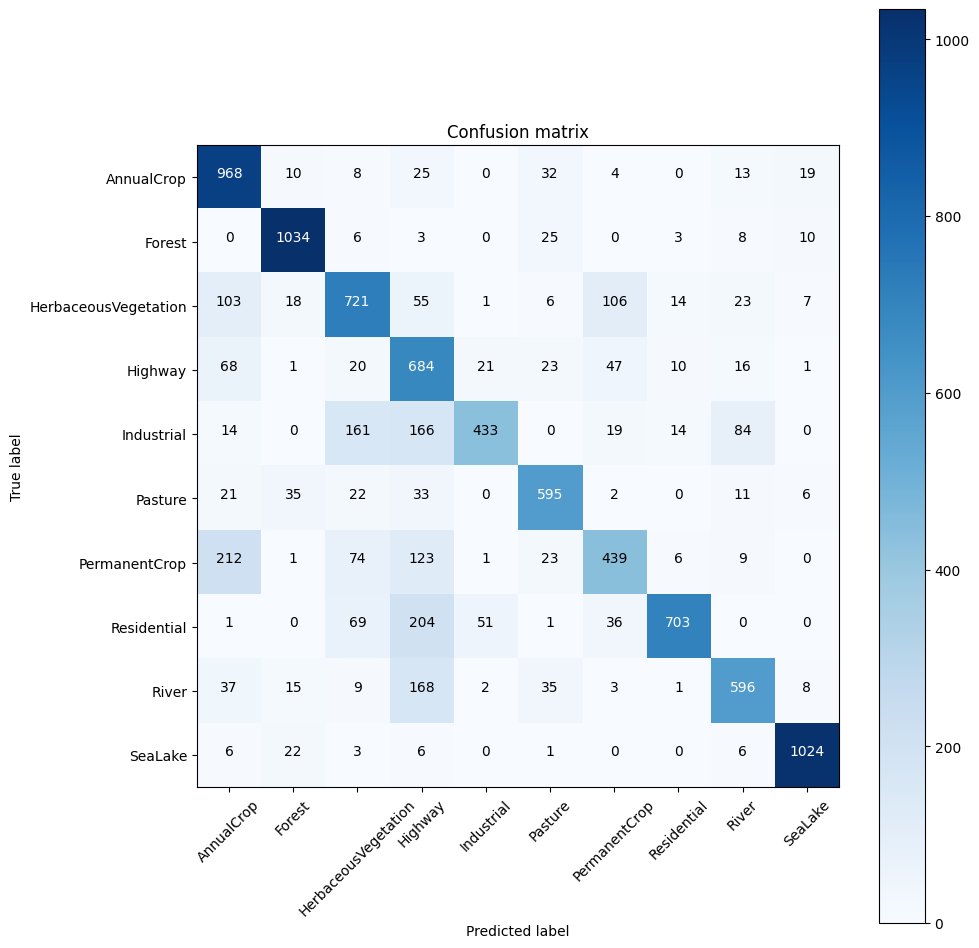

In [34]:
plot_confusion_matrix(cm, train_dataset.class_indices, cmap='Blues')

In [35]:
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve, auc

In [37]:
# Convert one-hot encoded labels (if necessary) to class indices
y_true_flat = np.argmax(np.concatenate(y_true), axis=1)  # Convert one-hot labels to indices
y_pred_flat = np.concatenate(y_pred)  # Predictions are already in integer format

# Calculate recall (macro-average for multi-class)
recall = recall_score(y_true_flat, y_pred_flat, average='macro')
print("Recall:", recall)

# Calculate F1-Score (macro-average for multi-class)
f1 = f1_score(y_true_flat, y_pred_flat, average='macro')
print("F1-Score:", f1)

# Calculate Precision (macro-average for multi-class)
precision = precision_score(y_true_flat, y_pred_flat, average='macro')
print("Precision:", precision)

Recall: 0.7400206843133692
F1-Score: 0.7408532722786767
Precision: 0.7702619491354816


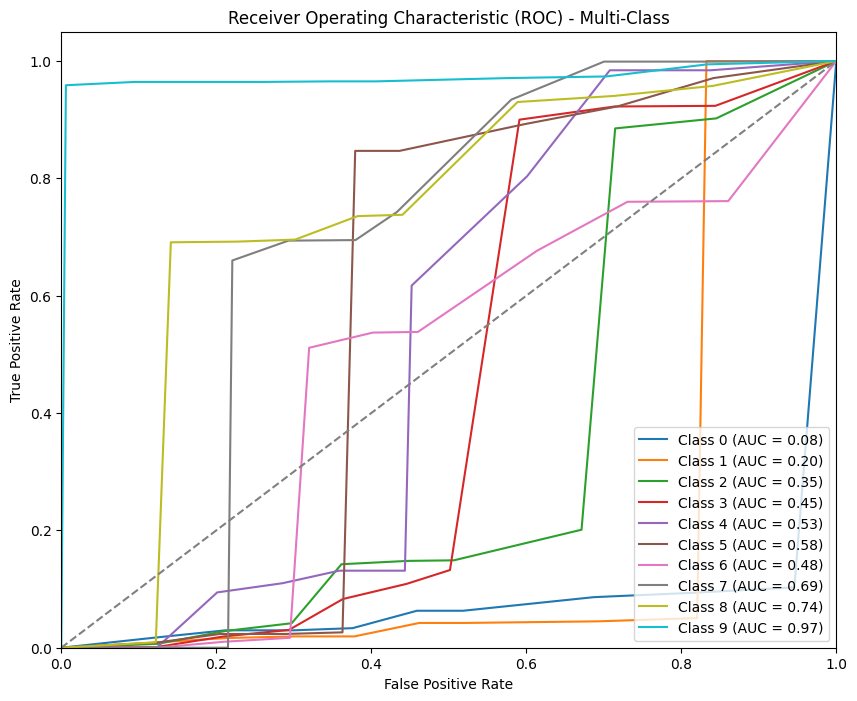

In [46]:
# Assuming `test_dataset` is your validation/test dataset and the model is `X_model`
# Get the true labels and predicted probabilities
y_true = y_true_flat
y_pred = y_pred_flat

# Convert true labels to one-hot encoding (binary format)
from sklearn.preprocessing import label_binarize
# Convert true labels to one-hot encoding (binary format)
y_true_bin = label_binarize(y_true_flat, classes=np.unique(y_true_flat))  # Use unique class labels from y_true_flat

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
n_classes = y_true_bin.shape[1]  # Get the number of classes

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_flat)  # Predictions may need adjustment
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for all classes
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot the diagonal (random guessing)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Multi-Class')
plt.legend(loc='lower right')
plt.show()